In [ ]:
from scipy import integrate
from scipy.linalg import expm
import pylab as pl
import numpy as np
import scipy as sp

# Conventions:
# B[i,a,b] = Gamma[i,a,b]*Lambda[b] has axes (physical, left virtual, right virtual),
# Lambda[i] = s[i] are schmidt values between sites (i-1, i),
# H_bond[i] is the bond hamiltonian between (i,i+1) with (only physical)

In [ ]:
def init_fm_mps(L):
    """ Returns FM Ising MPS"""
    d = 2
    B = []
    s = []
    for i in range(L):
        B.append(np.zeros([2, 1, 1]))
        B[-1][0, 0, 0] = 1
        s.append(np.ones([1]))
    s.append(np.ones([1]))
    return B, s


def init_ising_U_bond(g, J, L, delta):
    """ Returns bond hamiltonian and bond time-evolution"""
    sx = np.array([[0., 1.], [1., 0.]])
    sz = np.array([[1., 0.], [0., -1.]])
    d = 2

    U_bond = []
    H_bond = []
    for i in range(L-2):
        H = -J * np.kron(sz, sz) + g * np.kron(sx, np.eye(2))
        H_bond.append(np.reshape(H, (d, d, d, d)))
        U_bond.append(np.reshape(expm(-delta * H), (d, d, d, d)))

    H = -J * np.kron(sz, sz) + g * (np.kron(sx, np.eye(2)) + np.kron(np.eye(2),sx))
    H_bond.append(np.reshape(H, (d, d, d, d)))
    U_bond.append(np.reshape(expm(-delta * H), (d, d, d, d)))

    return U_bond, H_bond


def bond_expectation(B, s, O_list):
    " Expectation value for a bond operator "
    E = []
    L = len(B)
    for i_bond in range(L-1):
        BB = np.tensordot(B[i_bond], B[i_bond + 1], axes=(2, 1))
        sBB = np.tensordot(np.diag(s[i_bond]), BB, axes=(1, 1))
        C = np.tensordot(sBB, O_list[i_bond], axes=([1, 2], [2, 3]))
        sBB = np.conj(sBB)
        E.append( np.squeeze(np.tensordot(sBB, C, axes=([0, 3, 1, 2], [0, 1, 2, 3]))).item())
    return E


def site_expectation(B, s, O_list):
    " Expectation value for a site operator "
    E = []
    L = len(B)
    for isite in range(0, L):
        sB = np.tensordot(np.diag(s[isite]), B[isite], axes=(1, 1))
        C = np.tensordot(sB, O_list[isite], axes=(1, 0))
        sB = sB.conj()
        E.append(np.squeeze(np.tensordot(sB, C, axes=([0, 1, 2], [0, 2, 1]))).item())
    return E


def entanglement_entropy(s):
    " Returns the half chain entanglement entropy "
    S = []
    for i_bond in range(L+1):
        x = s[i_bond][s[i_bond] > 10**(-20)]**2
        S.append(-np.inner(np.log(x), x))
    return S


def sweep(B, s, U_bond, chi):
    """ Perform the imaginary time evolution of the MPS """
    L = len(B)
    d = B[0].shape[0]
    for k in [0, 1]:
        for i_bond in range(k, L-1, 2):
            ia = i_bond
            ib = i_bond + 1
            ic = i_bond + 2

            chia = B[ia].shape[1]
            chic = B[ib].shape[2]

            # Construct theta matrix and time evolution #
            theta = np.tensordot(B[ia], B[ib], axes=(2, 1))  # i a j b
            theta = np.tensordot(U_bond[i_bond], theta, axes=([2, 3], [0, 2]))  # ip jp a b
            theta = np.tensordot(np.diag(s[ia]), theta, axes=([1, 2]))  # a ip jp b
            theta = np.reshape(np.transpose(theta, (1, 0, 2, 3)), (d*chia, d*chic))  # ip a jp b

            # Schmidt deomposition #
            X, Y, Z = sp.linalg.svd(theta,full_matrices=0,lapack_driver='gesvd')
            chi2 = np.min([np.sum(Y > 10.**(-10)), chi])

            piv = np.zeros(len(Y), bool)
            piv[(np.argsort(Y)[::-1])[:chi2]] = True

            Y = Y[piv]
            invsq = np.sqrt(sum(Y**2))
            X = X[:, piv]
            Z = Z[piv, :]

            # Obtain the new values for B and s #
            s[ib] = Y / invsq
            X = np.reshape(X, (d, chia, chi2))
            X = np.transpose(
                np.tensordot(np.diag(s[ia]**(-1)), X, axes=(1, 1)), (1, 0, 2))
            B[ia] = np.tensordot(X, np.diag(s[ib]), axes=(2, 0))
            B[ib] = np.transpose(np.reshape(Z, (chi2, d, chic)), (1, 0, 2))

In [ ]:
def tebd_ising_gs(J, g, T, delta_tau_list, chi, L):

    B, s = init_fm_mps(L)
    sz = np.array([[1., 0.], [0., -1.]])

    for delta_tau in delta_tau_list:
        U_bond, H_bond = init_ising_U_bond(g, J, L, delta_tau)

        for i in range(int(T / delta_tau)):
            sweep(B, s, U_bond, chi)

        E = np.sum(bond_expectation(B, s, H_bond))
        m = np.sum(site_expectation(B, s, L*[sz]))
        S = entanglement_entropy(s)[L//2]

        print("E=%.6f" % E,
              "m=%.6f" % m,
              "S=%.6f" % S,
              "(TEBD, delta_tau =", delta_tau, ")")

    return E, m, S, B, s

def tebd_ising_quench(B, s, J, g, T, delta_t,chi, L):

    U_bond, H_bond = init_ising_U_bond(g, J, L, 1j*delta_t)
    t_list = []
    m_list = []
    E_list = []
    S_list = []

    for i in range(1,int(T / delta_t)+1):
            sweep(B, s, U_bond, chi)
            t_list.append(i*delta_t)
            m_list.append(site_expectation(B, s, L*[sz]))
            S_list.append(entanglement_entropy(s))
            E_list.append(np.real(np.sum(bond_expectation(B, s, H_bond))))

    return t_list,m_list,S_list,E_list

In [ ]:
# Part I: Imaginary Time Evolution
#
# Find the ground state using imaginary time evolution

E0_exact =  -13.191404952188883 # L = 8, J = 1, g = 1.5
J = 1.0
g = 1.5
chi = 5
T = 30
L = 8
delta_tau_list = [0.1,0.01]

E, m, S, B, s = tebd_ising_gs(J, g, T, delta_tau_list, chi, L)

print("\n|E_itebd - E_exact| =", np.abs(E - E0_exact))

E=-13.173931 m=-0.000000 S=0.182014 (TEBD, delta_tau = 0.1 )
E=-13.191690 m=-0.000000 S=0.155434 (TEBD, delta_tau = 0.01 )

|E_itebd - E_exact| = 0.00028538195060079374


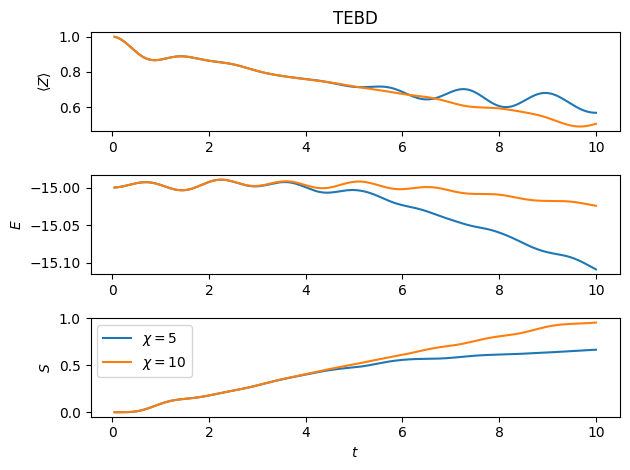

In [ ]:
# Part II: Real Time Evolution
# Global quench dynamics from real time evolution

J = 1.0
g = 0.5
T = 10.
delta_t = 0.05
L = 16

ax1 = pl.subplot(311)
pl.title('TEBD')
pl.ylabel('$\\langle Z\\rangle$')
ax2 = pl.subplot(312)
pl.ylabel('$E$')
ax3 = pl.subplot(313)
pl.ylabel('$S$')
pl.xlabel('$t$')

for chi in [5,10]:
    B, s = init_fm_mps(L)
    sz = np.array([[1., 0.], [0., -1.]])

    t_list,m_list,S_list,E_list = tebd_ising_quench(B, s, J, g, T, delta_t,chi, L)

    ax1.plot(t_list,np.real(np.array(m_list))[:,L//2])
    ax2.plot(t_list,np.real(E_list))
    ax3.plot(t_list,np.array(S_list)[:,L//2])

pl.legend(['$\\chi=5$','$\\chi=10$'])
pl.tight_layout()

E=-44.454727 m=0.001495 S=0.115283 (TEBD, delta_tau = 0.1 )
E=-44.537694 m=0.000000 S=0.091457 (TEBD, delta_tau = 0.01 )


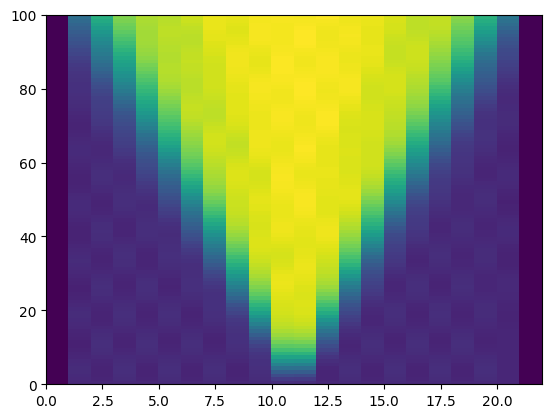

In [ ]:
# Local quench dynamics from real time evolution

J = 1.0
g = 2.0
chi = 5
T = 5
L = 21
delta_t = 0.05
delta_tau_list = [0.1,0.01]

E, m, S, B, s = tebd_ising_gs(J, g, T, delta_tau_list, chi, L)

sz = np.array([[1., 0.], [0., -1.]])
B[L//2] = np.tensordot(sz,B[L//2],axes=[1,0])

t_list,m_list,S_list,E_list = tebd_ising_quench(B, s, J, g, T, delta_t,chi, L)

pl.pcolor(np.array(S_list))
